In [ ]:
# !pip install yfinance pyspark -q

## Setup and Company Selection

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [3]:
# Start Spark session
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()

In [4]:
# Predefined list of popular companies
companies = {
    "1": ("Apple", "AAPL"),
    "2": ("Microsoft", "MSFT"),
    "3": ("Amazon", "AMZN"),
    "4": ("Google", "GOOGL"),
    "5": ("Meta (Facebook)", "META"),
    "6": ("NVIDIA", "NVDA"),
    "7": ("Tesla", "TSLA"),
    "8": ("Netflix", "NFLX"),
    "9": ("Adobe", "ADBE"),
    "10": ("S&P 500 Index", "^GSPC")
}

print("Choose a company to analyze:")
for k, (name, symbol) in companies.items():
    print(f"{k} → {name} ({symbol})")

company_choice = input("Enter the number corresponding to the company (1–10): ").strip()
company_name, ticker_symbol = companies.get(company_choice, companies["1"])  # default to Apple if invalid


Choose a company to analyze:
1 → Apple (AAPL)
2 → Microsoft (MSFT)
3 → Amazon (AMZN)
4 → Google (GOOGL)
5 → Meta (Facebook) (META)
6 → NVIDIA (NVDA)
7 → Tesla (TSLA)
8 → Netflix (NFLX)
9 → Adobe (ADBE)
10 → S&P 500 Index (^GSPC)
Enter the number corresponding to the company (1–10): 1


In [5]:
# Period options
print("Choose the time period:")
print("1 → 1 year")
print("2 → 3 years")
print("3 → 5 years")
print("4 → 10 years")
print("5 → max available")

period_options = {
    "1": "1y",
    "2": "3y",
    "3": "5y",
    "4": "10y",
    "5": "max"
}
period_choice = input("Enter your choice (1–5): ").strip()
selected_period = period_options.get(period_choice, "5y")  # default to 5y if invalid




Choose the time period:
1 → 1 year
2 → 3 years
3 → 5 years
4 → 10 years
5 → max available
Enter your choice (1–5): 3


## Download & Prepare Data

In [6]:
# Load stock data
print(f"Fetching last {selected_period} of data for {company_name} ({ticker_symbol})...")
stock = yf.Ticker(ticker_symbol)
df = stock.history(period=selected_period)

# Drop unnecessary columns
df = df.drop(columns=["Dividends", "Stock Splits"])

Fetching last 5y of data for Apple (AAPL)...


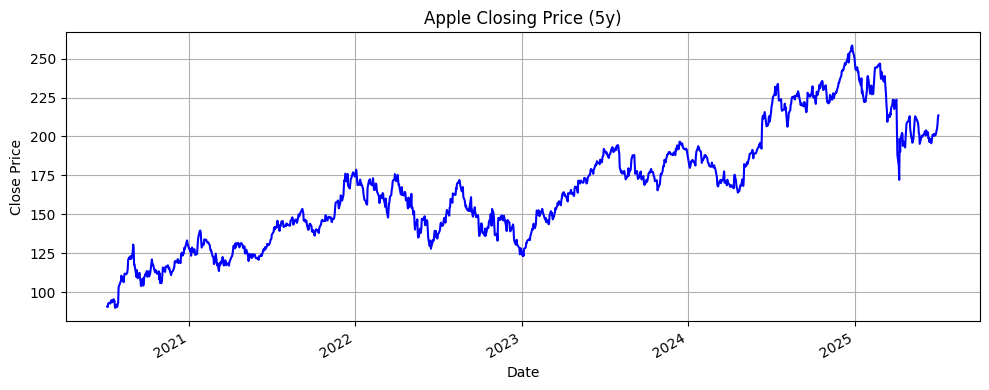

In [7]:
# Visualization - Plot Closing Price
plt.figure(figsize=(10, 4))
df["Close"].plot(title=f"{company_name} Closing Price ({selected_period})", color='blue')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Convert to Spark DataFrame
spark_df = spark.createDataFrame(df.reset_index()).dropna()
spark_df.show(5)

+-------------------+-----------------+-----------------+-----------------+-----------------+---------+
|               Date|             Open|             High|              Low|            Close|   Volume|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+
|2020-07-06 04:00:00|89.91637951083226| 91.3210188724847|89.88478608277487|90.85199737548828|118655600|
|2020-07-07 04:00:00|91.23112145924068|92.01120488127154|90.45832825923631|90.57011413574219|112424400|
|2020-07-08 04:00:00|91.54946038589766|92.71108256542591|91.46197031782751|92.67948913574219|117092000|
|2020-07-09 04:00:00|93.57380627647132|93.62727037791086| 92.0282198433449|93.07805633544922|125642800|
|2020-07-10 04:00:00|92.67220807313528|93.29919680465662|92.05980720131565| 93.2408676147461| 90257200|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+
only showing top 5 rows



## Feature Engineering

In [9]:
from pyspark.sql.functions import col, lag, when, mean, stddev
from pyspark.sql.window import Window

def calculate_features(data):
    window_spec_20 = Window.orderBy('Date').rowsBetween(-19, 0)
    window_spec_50 = Window.orderBy('Date').rowsBetween(-49, 0)
    window_spec_200 = Window.orderBy('Date').rowsBetween(-199, 0)

    # Moving Averages
    data = data.withColumn('20d_moving_avg', mean(col('Close')).over(window_spec_20))
    data = data.withColumn('50d_moving_avg', mean(col('Close')).over(window_spec_50))
    data = data.withColumn('200d_moving_avg', mean(col('Close')).over(window_spec_200))

    # Daily Return
    data = data.withColumn('daily_return', (col('Close') - lag('Close', 1).over(Window.orderBy('Date'))) / lag('Close', 1).over(Window.orderBy('Date')))

    # Volatility
    data = data.withColumn('volatility', stddev(col('daily_return')).over(window_spec_20))

    # Change, Gain, Loss
    data = data.withColumn('change', col('Close') - lag('Close', 1).over(Window.orderBy('Date')))
    data = data.withColumn('gain', when(col('change') > 0, col('change')).otherwise(0))
    data = data.withColumn('loss', when(col('change') < 0, -col('change')).otherwise(0))

    return data.dropna()

spark_df = calculate_features(spark_df)


## Visualize Raw and Engineered Data

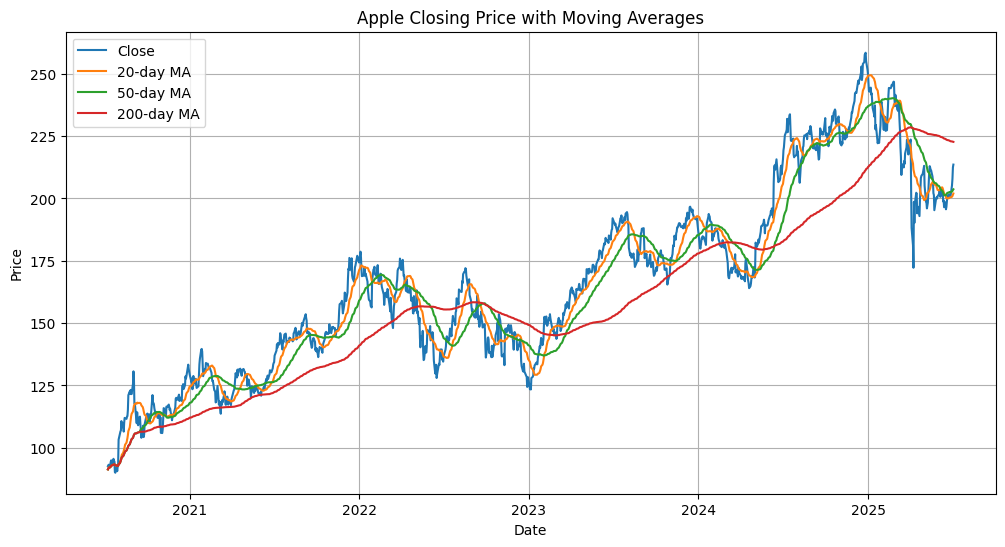

In [10]:
pandas_df = spark_df.select('Date', 'Close', '20d_moving_avg', '50d_moving_avg', '200d_moving_avg').toPandas()
pandas_df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['Close'], label='Close')
plt.plot(pandas_df['20d_moving_avg'], label='20-day MA')
plt.plot(pandas_df['50d_moving_avg'], label='50-day MA')
plt.plot(pandas_df['200d_moving_avg'], label='200-day MA')
plt.title(f"{company_name} Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## Split and Assemble Features

In [11]:
from pyspark.ml.feature import VectorAssembler

features = ['Open', 'High', 'Low', 'Close', 'Volume',
            '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
            'daily_return', 'volatility', 'change', 'gain', 'loss']

assembler = VectorAssembler(inputCols=features, outputCol='features')
spark_df = assembler.transform(spark_df)

train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=123)


## Model Training

In [12]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline

rf = RandomForestRegressor(featuresCol='features', labelCol='Close', predictionCol='rf_prediction')
gbt = GBTRegressor(featuresCol='features', labelCol='Close', predictionCol='gbt_prediction')

pipeline = Pipeline(stages=[rf, gbt])
model = pipeline.fit(train_data)


## Evaluate Model Performance

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_data)

evaluator_rf = RegressionEvaluator(labelCol='Close', predictionCol='rf_prediction', metricName='rmse')
evaluator_gbt = RegressionEvaluator(labelCol='Close', predictionCol='gbt_prediction', metricName='rmse')

rmse_rf = evaluator_rf.evaluate(predictions)
rmse_gbt = evaluator_gbt.evaluate(predictions)

print(f"RMSE (Random Forest): {rmse_rf:.4f}")
print(f"RMSE (GBT): {rmse_gbt:.4f}")


RMSE (Random Forest): 1.6911
RMSE (GBT): 1.6941


## Plot Predictions

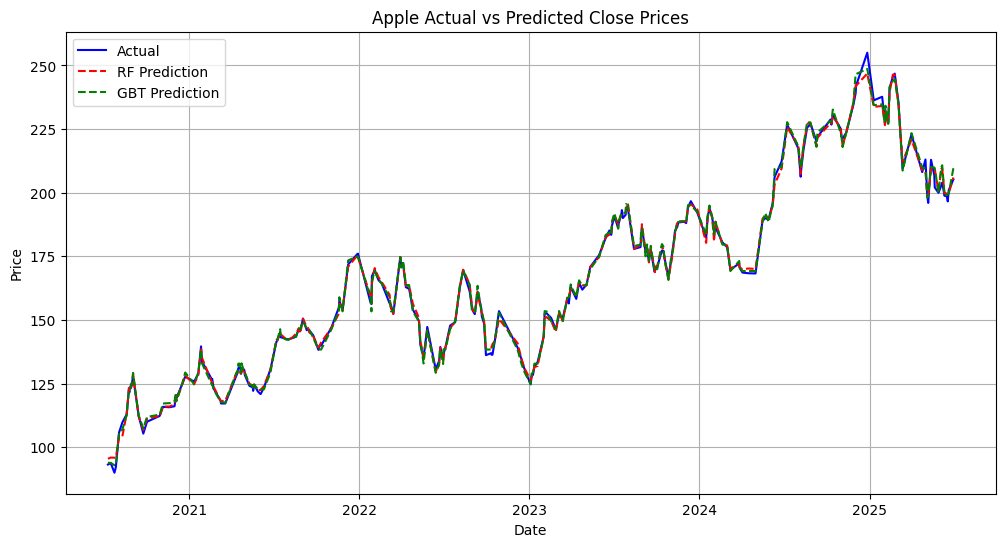

In [14]:
actual = predictions.select('Date', 'Close', 'rf_prediction', 'gbt_prediction').toPandas()
actual.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(actual['Close'], label='Actual', color='blue')
plt.plot(actual['rf_prediction'], label='RF Prediction', linestyle='--', color='red')
plt.plot(actual['gbt_prediction'], label='GBT Prediction', linestyle='--', color='green')
plt.title(f"{company_name} Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
